In [1]:
import numpy as np
import pandas as pd

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data Preprocessing

## Dataset

In [3]:
# load 'Online Job Postings' Kaggle dataset
df_job_postings_original = pd.read_csv('data/online-job-postings-dataset.csv')

In [4]:
# extract useful columns for the career profile
df_job_postings = df_job_postings_original[[
    'jobpost', # the original job post is included just in case other columns do not contain enough information
    'Title', 'JobDescription', 'JobRequirment',
    'RequiredQual',
    'ApplicationP'
]]

# drop any row that does not have a proper 'Title' or 'JobDescription'
df_job_postings = df_job_postings[df_job_postings['Title'].notna()]
df_job_postings = df_job_postings[df_job_postings['JobDescription'].notna()].reset_index(drop=True)

In [5]:
df_job_postings

,jobpost,Title,JobDescription,JobRequirment,RequiredQual,ApplicationP
0,AMERIA Investment Consulting Company\r\nJOB TI...,Chief Financial Officer,AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...,"To perform this job successfully, an\r\nindivi...","To apply for this position, please submit a\r\..."
1,Caucasus Environmental NGO Network (CENN)\r\nJ...,Country Coordinator,Public outreach and strengthening of a growing...,- Working with the Country Director to provide...,"- Degree in environmentally related field, or ...",Please send resume or CV toursula.kazarian@......
2,Manoff Group\r\nJOB TITLE: BCC Specialist\r\n...,BCC Specialist,The LEAD (Local Enhancement and Development fo...,- Identify gaps in knowledge and overseeing in...,"- Advanced degree in public health, social sci...",Please send cover letter and resume to Amy\r\n...
3,"Boutique ""Appollo""\r\nJOB TITLE: Saleswoman\r...",Saleswoman,Saleswoman will sell menswear and accessories.,NaN,"- Candidates should be female, 20-30 years old...","For further information, please contact Irina\..."
4,OSI Assistance Foundation - Armenian Branch Of...,Chief Accountant/ Finance Assistant,The Armenian Branch Office of the Open Society...,NaN,- University degree in finance/ accounting; \r...,"For submission of applications/ CVs, please\r\..."
...,...,...,...,...,...,...
15085,Macadamian AR CJSC\r\n\r\n\r\nTITLE: .NET Dev...,.NET Developer,The incumbent will develop software applicatio...,- Participate in all the steps of the software...,- 2 - 5 years of experience in software develo...,"To apply for this position, please email your ..."
15086,"""Transport PIU"" State Institution of the RA Mi...",Deputy Director,The incumbent will be responsible for supporti...,- Support the Director in organizing the activ...,"- University degree in Civil Engineering, Econ...",Interested candidates are asked to submit the\...
15087,Technolinguistics NGO\r\n\r\n\r\nTITLE: Senio...,Senior Creative UX/ UI Designer,A tech startup of Technolinguistics based in N...,- Work closely with product and business teams...,- At least 5 years of experience in Interface/...,"To apply for this position, please send your\r..."
15088,San Lazzaro LLC\r\n\r\n\r\nTITLE: Head of O...,Head of Online Sales Department,San Lazzaro LLC is looking for a well-experien...,- Handle the project activites of the online s...,- At least 1 year of experience in online sale...,Interested candidates can send their CVs to:\r...


## Dataset Label Aquisition
Many of the job labels are very similar but not entirely the same, so we have to group these similar job titles together to form a more general job category.

In [32]:
# helper function
# return: LIST of tokenized words
def preprocess(text, with_stopwords=False, lemmatize=True, stemming=False):
    text = text.lower()
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha()]
    if with_stopwords==False:
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if not word in stop_words]
    if lemmatize==True:
        lemmatizer=WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
    if stemming==True:
        stemmer=PorterStemmer()
        words = [stemmer.stem(word) for word in words]

    return words

In [7]:
# preprocess and tokenize all the job titles
job_titles = df_job_postings['Title']
job_titles_tokenized = job_titles.apply(preprocess)

In [8]:
import gensim.downloader as api

# load a pretrained word2vec model
model_w2v = api.load('word2vec-google-news-300')

In [9]:
# create document vectors for word embedding via average
def vectorize_document(documents, model):
    '''
    Generate vectors of a list of documents using a word embedding model
    '''

    features = []

    for tokens in documents:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model:
                try:
                    vectors.append(model[token])
                except KeyError: continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    
    return features

In [10]:
# vectorize each job title via average
vectorized_job_titles = vectorize_document(job_titles_tokenized, model=model_w2v)

In [119]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    s_score = silhouette_score(X, km.labels_)
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_, s_score

In [129]:
# find the best number of clusters by silhouette score
scores = []
for i in range(2, 100):
    _, _, s_score = mbkmeans_clusters(
        X=vectorized_job_titles,
        k=i,
        mb=500,
        print_silhouette_values=False
    )
    scores.append(s_score)

c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2
Silhouette coefficient: 0.11
Inertia:47355.33056837851


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3
Silhouette coefficient: 0.08
Inertia:45219.41286506242


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4
Silhouette coefficient: 0.10
Inertia:46159.392230315374


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 5
Silhouette coefficient: 0.10
Inertia:41078.6230571767


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 6
Silhouette coefficient: 0.08
Inertia:41284.19105595874


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 7
Silhouette coefficient: 0.10
Inertia:39491.229585416455
For n_clusters = 8


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


Silhouette coefficient: 0.09
Inertia:39313.72530811372


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 9
Silhouette coefficient: 0.10
Inertia:37386.23928683061


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 10
Silhouette coefficient: 0.12
Inertia:36508.161114071234


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 11
Silhouette coefficient: 0.11
Inertia:36246.245810667715
For n_clusters = 12


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


Silhouette coefficient: 0.09
Inertia:35462.37160719347


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 13
Silhouette coefficient: 0.07
Inertia:35818.891595784815
For n_clusters = 14


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


Silhouette coefficient: 0.10
Inertia:35333.942953705504


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 15
Silhouette coefficient: 0.10
Inertia:33753.229704006655


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 16
Silhouette coefficient: 0.12
Inertia:33199.08018566824


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 17
Silhouette coefficient: 0.11
Inertia:32839.19063098314
For n_clusters = 18


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


Silhouette coefficient: 0.10
Inertia:33416.155371644825


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 19
Silhouette coefficient: 0.12
Inertia:31991.93542250681


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 20
Silhouette coefficient: 0.14
Inertia:30638.531176557957


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 21
Silhouette coefficient: 0.12
Inertia:31134.537576138235


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 22
Silhouette coefficient: 0.11
Inertia:31229.06161637942


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 23
Silhouette coefficient: 0.13
Inertia:30302.53453673642


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 24
Silhouette coefficient: 0.13
Inertia:30126.452438622906


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 25
Silhouette coefficient: 0.14
Inertia:29256.136459844372
For n_clusters = 26


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


Silhouette coefficient: 0.13
Inertia:29756.350084746144


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 27
Silhouette coefficient: 0.14
Inertia:29011.708481526977


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 28
Silhouette coefficient: 0.15
Inertia:28291.140014529083


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 29
Silhouette coefficient: 0.15
Inertia:28420.956228570623


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 30
Silhouette coefficient: 0.15
Inertia:28170.58724717598


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 31
Silhouette coefficient: 0.14
Inertia:28287.958185862124


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 32
Silhouette coefficient: 0.15
Inertia:27856.992256024045


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 33
Silhouette coefficient: 0.14
Inertia:27783.831885627522


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 34
Silhouette coefficient: 0.15
Inertia:27023.95202486168


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 35
Silhouette coefficient: 0.17
Inertia:26509.271990037414


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 36
Silhouette coefficient: 0.15
Inertia:26759.416664326367
For n_clusters = 37


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


Silhouette coefficient: 0.15
Inertia:26789.472675943696


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 38
Silhouette coefficient: 0.15
Inertia:26419.898203914236


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 39
Silhouette coefficient: 0.15
Inertia:26543.89417707379


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 40
Silhouette coefficient: 0.16
Inertia:26079.827414884712


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 41
Silhouette coefficient: 0.17
Inertia:25746.025032734622


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 42
Silhouette coefficient: 0.18
Inertia:25347.63907915088


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 43
Silhouette coefficient: 0.17
Inertia:25418.492329658337


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 44
Silhouette coefficient: 0.16
Inertia:25848.770904243825


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 45
Silhouette coefficient: 0.17
Inertia:25274.01329781402


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 46
Silhouette coefficient: 0.18
Inertia:24636.87472931819


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 47
Silhouette coefficient: 0.19
Inertia:24605.1013433928


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 48
Silhouette coefficient: 0.17
Inertia:24655.495890012855


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 49
Silhouette coefficient: 0.17
Inertia:24707.52231961341


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 50
Silhouette coefficient: 0.17
Inertia:24645.937130363433


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 51
Silhouette coefficient: 0.16
Inertia:23865.29372852291


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 52
Silhouette coefficient: 0.18
Inertia:23886.58611611557


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 53
Silhouette coefficient: 0.19
Inertia:23541.8892961579


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 54
Silhouette coefficient: 0.18
Inertia:24172.619506940453


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 55
Silhouette coefficient: 0.18
Inertia:23679.444845102607


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 56
Silhouette coefficient: 0.18
Inertia:23354.480646004286


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 57
Silhouette coefficient: 0.20
Inertia:23201.879245745622


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 58
Silhouette coefficient: 0.17
Inertia:23285.26037389945


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 59
Silhouette coefficient: 0.18
Inertia:23568.89049329067


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 60
Silhouette coefficient: 0.19
Inertia:22892.823820121535


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 61
Silhouette coefficient: 0.20
Inertia:22554.734493623597


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 62
Silhouette coefficient: 0.19
Inertia:22843.230408362586


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 63
Silhouette coefficient: 0.19
Inertia:22635.202746541472


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 64
Silhouette coefficient: 0.19
Inertia:22848.272167219806


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 65
Silhouette coefficient: 0.18
Inertia:22664.487221912666


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 66
Silhouette coefficient: 0.20
Inertia:22439.076336288697


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 67
Silhouette coefficient: 0.21
Inertia:21902.04239734648


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 68
Silhouette coefficient: 0.21
Inertia:22046.762544211313


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 69
Silhouette coefficient: 0.19
Inertia:22395.767730828


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 70
Silhouette coefficient: 0.20
Inertia:22283.548219803004


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 71
Silhouette coefficient: 0.21
Inertia:21809.729937901062


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 72
Silhouette coefficient: 0.21
Inertia:21713.110821584603


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 73
Silhouette coefficient: 0.22
Inertia:21311.958071734916


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 74
Silhouette coefficient: 0.21
Inertia:21684.243753467887


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 75
Silhouette coefficient: 0.21
Inertia:21272.299366331117


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 76
Silhouette coefficient: 0.21
Inertia:20986.9219537582


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 77
Silhouette coefficient: 0.21
Inertia:21300.653981057687


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 78
Silhouette coefficient: 0.20
Inertia:20920.122965143724


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 79
Silhouette coefficient: 0.21
Inertia:21306.384942770943


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 80
Silhouette coefficient: 0.21
Inertia:21034.41553901881


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 81
Silhouette coefficient: 0.21
Inertia:21450.66755243313


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 82
Silhouette coefficient: 0.21
Inertia:20903.86274438094


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 83
Silhouette coefficient: 0.22
Inertia:20674.145789922248


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 84
Silhouette coefficient: 0.22
Inertia:20887.414145514085


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 85
Silhouette coefficient: 0.23
Inertia:20611.39070596435


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 86
Silhouette coefficient: 0.22
Inertia:20914.07984510131


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 87
Silhouette coefficient: 0.22
Inertia:20784.084676394552


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 88
Silhouette coefficient: 0.22
Inertia:20555.171828782066


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 89
Silhouette coefficient: 0.23
Inertia:20640.734646838624


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 90
Silhouette coefficient: 0.22
Inertia:20507.7479717459


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 91
Silhouette coefficient: 0.21
Inertia:20541.38549774305


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 92
Silhouette coefficient: 0.21
Inertia:19914.156978086994


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 93
Silhouette coefficient: 0.23
Inertia:20101.86426325515


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 94
Silhouette coefficient: 0.23
Inertia:20157.96471869652


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 95
Silhouette coefficient: 0.23
Inertia:19876.958017255063


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 96
Silhouette coefficient: 0.24
Inertia:19984.40479696871


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 97
Silhouette coefficient: 0.22
Inertia:19986.846225201927


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 98
Silhouette coefficient: 0.23
Inertia:19870.229262906254


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 99
Silhouette coefficient: 0.23
Inertia:19553.343210712937


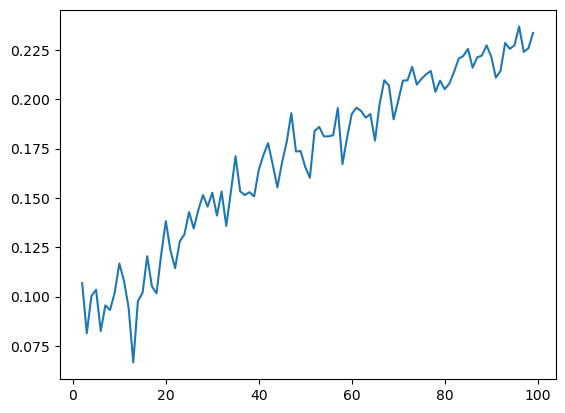

In [132]:
import matplotlib.pyplot as plt
plt.plot(list(range(2, 100)), scores)
plt.show()

In [133]:
# find the best number of clusters by silhouette score
scores = []
for i in range(200, 1000, 50):
    _, _, s_score = mbkmeans_clusters(
        X=vectorized_job_titles,
        k=i,
        mb=500,
        print_silhouette_values=False
    )
    scores.append(s_score)

c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 200
Silhouette coefficient: 0.28
Inertia:15825.359843852397


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 250
Silhouette coefficient: 0.32
Inertia:14617.628627013433


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 300
Silhouette coefficient: 0.33
Inertia:13824.50251127476


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 350
Silhouette coefficient: 0.35
Inertia:13071.68640267748


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 400
Silhouette coefficient: 0.38
Inertia:12453.440300247179


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 450
Silhouette coefficient: 0.39
Inertia:11893.413274632052


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 500
Silhouette coefficient: 0.39
Inertia:11304.147320019547


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 550
Silhouette coefficient: 0.41
Inertia:10809.324244532638


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 600
Silhouette coefficient: 0.42
Inertia:10282.081075416378


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 650
Silhouette coefficient: 0.43
Inertia:10261.3728999326


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 700
Silhouette coefficient: 0.45
Inertia:9642.38753686911


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 750
Silhouette coefficient: 0.45
Inertia:9419.585956817464


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 800
Silhouette coefficient: 0.45
Inertia:9448.488293959916


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 850
Silhouette coefficient: 0.47
Inertia:8891.61019425498


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 900
Silhouette coefficient: 0.47
Inertia:8745.287973470695


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 950
Silhouette coefficient: 0.49
Inertia:8389.989457042118


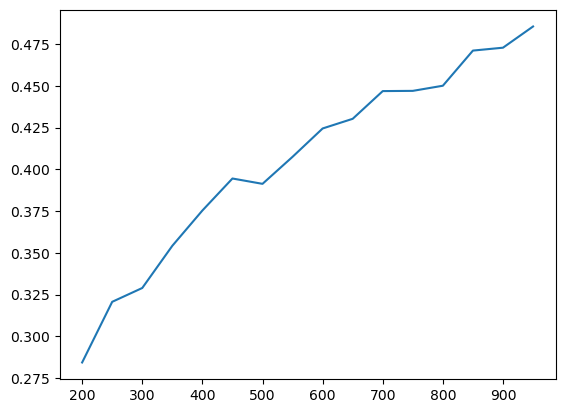

In [134]:
import matplotlib.pyplot as plt
plt.plot(list(range(200, 1000, 50)), scores)
plt.show()

In [135]:
# find the best number of clusters by silhouette score
scores = []
for i in range(1000, 5000, 100):
    _, _, s_score = mbkmeans_clusters(
        X=vectorized_job_titles,
        k=i,
        mb=500,
        print_silhouette_values=False
    )
    scores.append(s_score)

c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1000
Silhouette coefficient: 0.48
Inertia:8343.486808075375


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1100
Silhouette coefficient: 0.50
Inertia:7777.411516201758


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1200
Silhouette coefficient: 0.51
Inertia:7761.139395784848


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1300
Silhouette coefficient: 0.52
Inertia:7373.042643033305


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1400
Silhouette coefficient: 0.53
Inertia:6887.373218033455


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1500
Silhouette coefficient: 0.54
Inertia:6830.686332492045


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1600
Silhouette coefficient: 0.55
Inertia:6390.16845304599


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1700
Silhouette coefficient: 0.55
Inertia:6204.529100369795


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1800
Silhouette coefficient: 0.56
Inertia:5924.020241958763


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1900
Silhouette coefficient: 0.54
Inertia:7176.675247781882


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2000
Silhouette coefficient: 0.57
Inertia:5662.494243199713


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2100
Silhouette coefficient: 0.58
Inertia:5163.984166894702


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2200
Silhouette coefficient: 0.56
Inertia:6697.64243208389


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2300
Silhouette coefficient: 0.56
Inertia:6559.62461370682


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2400
Silhouette coefficient: 0.57
Inertia:6174.540756537664


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2500
Silhouette coefficient: 0.57
Inertia:6413.947063407154


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2600
Silhouette coefficient: 0.58
Inertia:6034.977155981688


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2700
Silhouette coefficient: 0.62
Inertia:4029.9464895121487


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2800
Silhouette coefficient: 0.60
Inertia:5404.028642280558


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2900
Silhouette coefficient: 0.59
Inertia:5649.454779404123


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3000
Silhouette coefficient: 0.62
Inertia:4632.43962957574


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3100
Silhouette coefficient: 0.62
Inertia:4414.659408898083


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3200
Silhouette coefficient: 0.64
Inertia:3459.049868439754


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3300
Silhouette coefficient: 0.61
Inertia:4963.3186509241505


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3400
Silhouette coefficient: 0.61
Inertia:4765.006750420458


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3500
Silhouette coefficient: 0.64
Inertia:3778.5435306793734


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3600
Silhouette coefficient: 0.63
Inertia:4087.1862214795615


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3700
Silhouette coefficient: 0.63
Inertia:4227.417484854356


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3800
Silhouette coefficient: 0.64
Inertia:3879.8698453737034


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3900
Silhouette coefficient: 0.65
Inertia:3409.080062117052


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4000
Silhouette coefficient: 0.65
Inertia:3619.717380637986


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4100
Silhouette coefficient: 0.64
Inertia:3611.674678347521


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4200
Silhouette coefficient: 0.64
Inertia:3826.136585115016


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4300
Silhouette coefficient: 0.66
Inertia:3493.9657346415693


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4400
Silhouette coefficient: 0.67
Inertia:2747.3641925810257


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4500
Silhouette coefficient: 0.67
Inertia:2774.458000238058


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4600
Silhouette coefficient: 0.65
Inertia:3496.3123415478744


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4700
Silhouette coefficient: 0.67
Inertia:2763.1063398242272


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4800
Silhouette coefficient: 0.68
Inertia:2302.41215587872


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4900
Silhouette coefficient: 0.69
Inertia:2294.6910943352823


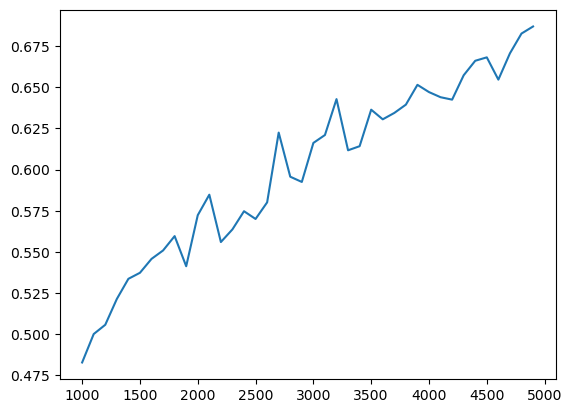

In [136]:
import matplotlib.pyplot as plt
plt.plot(list(range(1000, 5000, 100)), scores)
plt.show()

In [13]:
# get the clusters
df_clusters = pd.DataFrame({
    "text": job_titles,
    "tokens": [" ".join(text) for text in job_titles_tokenized],
    "cluster": cluster_labels
})

In [14]:
df_clusters

,text,tokens,cluster
0,Chief Financial Officer,chief financial officer,34
1,Country Coordinator,country coordinator,10
2,BCC Specialist,bcc specialist,38
3,Saleswoman,saleswoman,11
4,Chief Accountant/ Finance Assistant,chief finance assistant,32
...,...,...,...
15085,.NET Developer,developer,8
15086,Deputy Director,deputy director,17
15087,Senior Creative UX/ UI Designer,senior creative ui designer,18
15088,Head of Online Sales Department,head online sale department,30


In [15]:
print("Most representative terms per cluster (based on centroids):")
for i in range(40):
    tokens_per_cluster = ""
    most_representative = model_w2v.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Most representative terms per cluster (based on centroids):
Cluster 0: merchandiser merchandising visual_merchandiser merchandisers merchandizing 
Cluster 1: engineer engineering mechanical_engineer electrical_engineer Mike_Di_Filippo 
Cluster 2: sale manager buyer sold sell 
Cluster 3: manager vice_president manger director supervisor 
Cluster 4: finance treasurer executive vice_president Ellen_Roseman_writes 
Cluster 5: developer developers Active_Endpoints_www.activevos.com Panda_Software_www.pandasoftware.com Developer 
Cluster 6: administrative assistant adminstrative Sherri_Sera representative_Laurie_Hamit 
Cluster 7: journalist writer researcher scientist editor 
Cluster 8: developer developers Developer Developers Jack_Antaramian 
Cluster 9: translator interpreter interpretor FOREIGN_MINISTER_Via PRESIDENT_ABBAS_Via 
Cluster 10: administrator coordinator director secretary adminstrator 
Cluster 11: receptionist waitress salesperson cashier saleswoman 
Cluster 12: java developer

In [26]:
for n in range(40):
    test_cluster = n
    most_representative_docs = np.argsort(
        np.linalg.norm(vectorized_job_titles - clustering.cluster_centers_[test_cluster], axis=1)
    )
    for d in most_representative_docs[:10]:
        print(job_titles[d])
    print('----------------------------------------')

Merchandiser
Reseller/ Merchandiser
Merchandiser, Vanadzor
Merchandiser, Yerevan
Merchandiser
Merchandiser
Merchandiser
Merchandiser
Merchandiser
Merchandiser
----------------------------------------
Senior Software QA Engineer
Senior Software QA Engineer
Senior Software Engineer (EDA)
Senior Software Engineer
Senior Software Engineer
Senior Software Engineer  Java/DBMS
Senior Software Engineer
Senior Software Engineer
Senior Software Engineer
Senior Software Engineer
----------------------------------------
Sales Manager
Sales Manager
Sales Manager
Sales Manager
Sales Manager
Account/ Sales Manager
Sales Manager
Sales Manager
Sales Manager
Sales Manager
----------------------------------------
BTL Manager
Office Manager of the Country Director
Business Center Manager
Business Center Manager
Manager of Commercial Department
Manager of Commercial Department
Manager of Commercial Department
Manager of Commercial Department
Business Manager
Business Manager
-------------------------------

In [17]:
# add the cluster category to each job posting
df_job_postings['cluster'] = df_clusters['cluster']

In [19]:
# save the labeled dataset to local
df_job_postings.to_csv('data/job_postings_labeled.csv')

## Career Classification Training based on Job Description

In [27]:
from sklearn.model_selection import train_test_split

In [18]:
df_job_postings.head()

,jobpost,Title,JobDescription,JobRequirment,RequiredQual,ApplicationP,cluster
0,AMERIA Investment Consulting Company\r\nJOB TI...,Chief Financial Officer,AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...,"To perform this job successfully, an\r\nindivi...","To apply for this position, please submit a\r\...",34
1,Caucasus Environmental NGO Network (CENN)\r\nJ...,Country Coordinator,Public outreach and strengthening of a growing...,- Working with the Country Director to provide...,"- Degree in environmentally related field, or ...",Please send resume or CV toursula.kazarian@......,10
2,Manoff Group\r\nJOB TITLE: BCC Specialist\r\n...,BCC Specialist,The LEAD (Local Enhancement and Development fo...,- Identify gaps in knowledge and overseeing in...,"- Advanced degree in public health, social sci...",Please send cover letter and resume to Amy\r\n...,38
3,"Boutique ""Appollo""\r\nJOB TITLE: Saleswoman\r...",Saleswoman,Saleswoman will sell menswear and accessories.,NaN,"- Candidates should be female, 20-30 years old...","For further information, please contact Irina\...",11
4,OSI Assistance Foundation - Armenian Branch Of...,Chief Accountant/ Finance Assistant,The Armenian Branch Office of the Open Society...,NaN,- University degree in finance/ accounting; \r...,"For submission of applications/ CVs, please\r\...",32


In [23]:
df_job_postings.groupby(['cluster'], sort=True).size()

cluster
0       31
1      776
2      542
3      908
4      211
5      356
6      301
7      231
8      119
9      172
10     500
11     166
12     269
13     289
14      86
15     258
16    1772
17     270
18     294
19     528
20     485
21     163
22      78
23     230
24     107
25     521
26      50
27     415
28     146
29     145
30     939
31     312
32     430
33     241
34     341
35    1363
36     135
37     107
38     596
39     207
dtype: int64

In [30]:
# create training and testing datasets
X = df_job_postings['JobDescription']
y = df_job_postings['cluster']

In [34]:
# preprocess the dataset
X_tokenized = X.apply(preprocess, stemming=True)

### Model 1: Word2Vec + Classifier

In [47]:
from os import cpu_count
from gensim.models import Word2Vec

model_w2v = Word2Vec(sentences=X_tokenized, vector_size=1000, workers=cpu_count(), seed=7600)

In [57]:
# save w2v model
model_w2v.save('models/w2v_online_job_descriptions.model')  

In [51]:
# vectorize the X data
X_vectorized = vectorize_document(X, model_w2v.wv)

In [115]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.3, shuffle=True, random_state=7600)

**Linear Support Vector Machine**

In [65]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score

In [62]:
clf_sgd = SGDClassifier(random_state=7600)
clf_sgd.fit(X_train, y_train)

SGDClassifier(random_state=7600)

In [66]:
accuracy_score(y_test, clf_sgd.predict(X_test))

0.1334216920698034

**ExtraTrees**

In [67]:
from sklearn.ensemble import ExtraTreesClassifier

In [69]:
clf_etc = ExtraTreesClassifier(n_estimators=200, random_state=7600)
clf_etc.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=200, random_state=7600)

In [71]:
accuracy_score(y_test, clf_etc.predict(X_test))

0.36492158162138283

**SVM**

In [72]:
from sklearn import svm

In [73]:
clf_rbf = svm.SVC(kernel='rbf')
clf_rbf.fit(X_train, y_train)

SVC()

In [74]:
accuracy_score(y_test, clf_rbf.predict(X_test))

0.12016788159929313

In [55]:
import sys
sys.path.append('packages/ontology_profiles/career_profile')

from packages.ontology_profiles.career_profile.Job import Job

In [47]:
from JobBasicInfo import JobBasicInfo
from JobApplication import JobApplication
from JobQualification import JobQualification

In [52]:
job_basic_info = JobBasicInfo('hi1', '2', '3')
job_qualification = JobQualification('This is a sample job qualification text.')
job_application = JobApplication('This is some application procedure.')

In [56]:
job = Job(job_basic_info, job_qualification, job_application)